## Demonstration on Using MultiFlow and CommsFlow

This notebook is a demonstration on the use of MultiFlow and CommsFlow for the coordination of multiple devices via a single "agent". With the exception of the graphs, the code here is identical to `multiflow_demo.py` with the purpose of walking people through the step-by-step creation of the model. 

The model is a simple example of using `fmdtools` to create [System of Systems](https://en.wikipedia.org/wiki/System_of_systems) or an [Agent-Based](https://en.wikipedia.org/wiki/Agent-based_model) model. Depending on the representation and the goal of the model, it could be considered a [Multiagent System](https://en.wikipedia.org/wiki/Multi-agent_system) but the fundamental setup works all the same. 

When using `fmdtools` to do this, indivudal entities known as agents are programmed as functions, while the interactions between them are built using flows. Agents can represent a variety of things such as a representation of a more complicated system (such as a drone) or a software agent that helps control the others. The flows can be interactions such as communication channels or the environment that the agents exist in. For further explanation, see [this part of the documentation](https://nasa.github.io/fmdtools/docs/Development%20Guide.html#structuring-a-model)

The concept for this example is as follows: two `mover` agents move in both the x and y direction. A `coordinator` agent is tasked with sending the messages to tell them how to move within the environment.

In [1]:
import inspect

### Bulding Flows
The first step is creating the flows and states that connect the model. This includes using a `LocationState` as the default starting location. This is given to the Communications channel which uses `CommsFlow` to allow for communications agent, and the locaiton `MultiFlow` to represent an "environment". Finally there is a parameter setup for the `Mover` agent, the purpose of which is elaborated on below.

In [2]:
from multiflow_demo import LocationState, Communications, Location, MoveParam
print(inspect.getsource(LocationState))
print(inspect.getsource(Location))
print(inspect.getsource(Communications))
print(inspect.getsource(MoveParam))

class LocationState(State):
    x: float = 0.0
    y: float = 0.0

class Location(MultiFlow):
    container_s = LocationState

class Communications(CommsFlow):
    container_s = LocationState

class MoveParam(Parameter):
    x_up: float = 0.0
    y_up: float = 0.0



Next is the development of the  `Mover` agents. When the model is constructed, there will be two Movers. The first moves in the x direction and the second in the y. That is the purpose of the `MoverParam` and the if statement in the behavior function. When the model is initilized later, the two movers are sent parameters to turn on the x_up and y_up which determines how they move. 

Other parts necessary in the model are the initiation, which requires making a communications channel and a local copy of the location to track the state. The dynamic behavior function uses the increment (`inc`) function to move the device in the direction needed on each step. With that same update, it makes sure that it updates it's internal info from it's location to ensure that it can send out the correct information to the `coordinator` agent.

In [3]:
from multiflow_demo import Mover
print(inspect.getsource(Mover))    

class Mover(Function):
    container_p = MoveParam
    flow_communications = Communications
    flow_location = Location

    def __init__(self, name='mover', flows={}, **kwargs):
        super().__init__(name=name, flows=flows, **kwargs)
        self.internal_info = self.communications.create_comms(name)
        self.loc = self.location.create_local(name)

    def dynamic_behavior(self, time):
        # move
        self.loc.s.inc(x=self.p.x_up, y=self.p.y_up)
        # the inbox should be cleared each timestep to allow new messages
        self.internal_info.clear_inbox()

    def behavior(self, time):
        # recieve messages
        self.internal_info.receive()
        # communicate
        if self.p.x_up != 0.0:
            self.internal_info.s.x = self.loc.s.x
            self.internal_info.send("all", "local", "x")
        elif self.p.y_up != 0.0:
            self.internal_info.s.y = self.loc.s.y
            self.internal_info.send("all", "local", "y")

    def find_classifica

Finally, there is the creation of the `Coordinator` agent. It's main goal to allow for the transfer of information between the agents by receiving and transmiting information to the agents.

In [4]:
from multiflow_demo import Coordinator
print(inspect.getsource(Coordinator))    

class Coordinator(Function):
    flow_communications = Communications

    def __init__(self, name='coordinator', flows={}, **kwargs):
        super().__init__(name=name, flows=flows, **kwargs)
        self.coord_view = self.communications.create_comms(
            name, ports=["mover_1", "mover_2"])

    def dynamic_behavior(self, time):
        self.coord_view.clear_inbox()

    def behavior(self, time):
        self.coord_view.receive()
        self.coord_view.update("local", "mover_1", "y")
        self.coord_view.update("local", "mover_2", "x")



After building all the functions and flow, the entire model is put together and initialized with the correct parameters. Each flow and then function is added. Not the "p = {"x_up":1.0}" and "p = {"y_up":1.0} when creating the two movers. This refers back to the behavior function when making the `Mover` agent before, allowing for each one to behave in its own way.

In [5]:
from multiflow_demo import TestModel
print(inspect.getsource(TestModel))    

class TestModel(FunctionArchitecture):
    default_sp = dict(end_time=10)

    def init_architecture(self, **kwargs):

        self.add_flow("communications", Communications)
        self.add_flow("location",  Location)
        self.add_fxn("mover_1", Mover, "communications", "location", p={"x_up": 1.0})
        self.add_fxn("mover_2", Mover, "communications", "location", p={"y_up": 1.0})

        self.add_fxn("coordinator", Coordinator, "communications")



Before running the model, we start with loading up the model and using the `FunctionArchitectureGraph` function to view the components and their relations to eachother. The `CommsFlow` and `MultiFlow` nodes are represented by octogons and hexagons, respectively. This is different than the circle nodes in regular flows. See `default_node_kwargs` in `fmdtools.analyze.graph` for the different node shapes and colors. 

In [6]:
from fmdtools.analyze.graph import FunctionArchitectureGraph

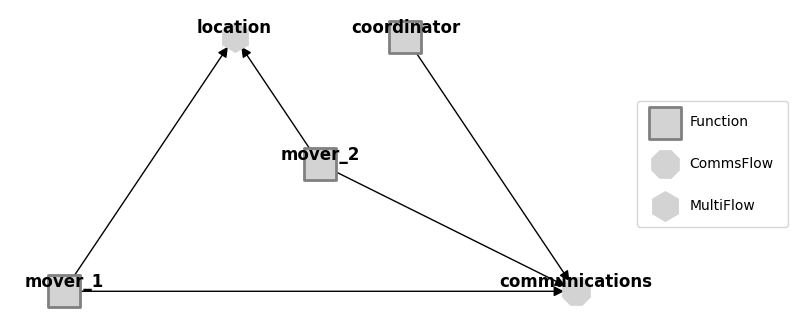

In [7]:
mdl = TestModel()
mg = FunctionArchitectureGraph(mdl)
mg.set_edge_labels(title='')
fig, ax = mg.draw(figsize=(8,4))

Besides the model itself, we can use `FunctionArchitectureTypeGraph` to create a graph representation of hte model classes, showing the containment relationship between function classes and flow classes in the model.

In [8]:
from fmdtools.analyze.graph import FunctionArchitectureTypeGraph

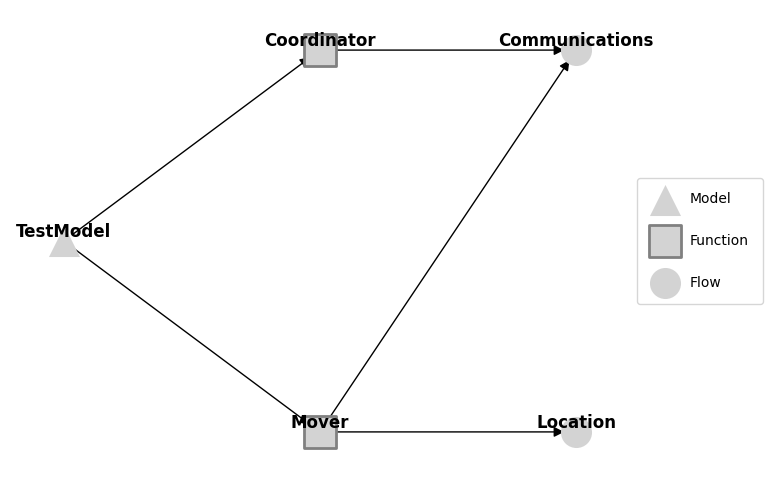

In [9]:
tg = FunctionArchitectureTypeGraph(mdl)
tg.set_edge_labels(title='')
fig, ax = tg.draw(figsize=(8,6))

Finally, we can run the model and view it's history via `fmdtools.sim.propagate`. The communication is setup such that mover_1 is supposed to go 25 and transmit that information to allow for mover_2 to do the same.

In [10]:
mdl.flows["communications"].mover_1.s.x=25
mdl.flows["communications"].mover_1.send("mover_2")
from fmdtools.sim import propagate

result, mdlhist = propagate.nominal(mdl,track='all', desired_result={'graph': FunctionArchitectureGraph})
#fig = result.graph.draw(figsize=(8,6)) #graph can be drawn, but it's the same as before since it's nominal
mdlhist

flows.communications.s.x:      array(11)
flows.communications.s.y:      array(11)
flows.communications.mover_1.s.x: array(11)
flows.communications.mover_1.s.y: array(11)
flows.communications.mover_1_out.s.x: array(11)
flows.communications.mover_1_out.s.y: array(11)
flows.communications.mover_2.s.x: array(11)
flows.communications.mover_2.s.y: array(11)
flows.communications.mover_2_out.s.x: array(11)
flows.communications.mover_2_out.s.y: array(11)
flows.communications.coordinator.s.x: array(11)
flows.communications.coordinator.s.y: array(11)
flows.communications           array(11)
flows.communications           array(11)
flows.communications           array(11)
flows.communications           array(11)
flows.communications           array(11)
flows.communications           array(11)
flows.communications           array(11)
flows.communications           array(11)
flows.communications           array(11)
flows.communications           array(11)
flows.location.s.x:            array(11)
flo

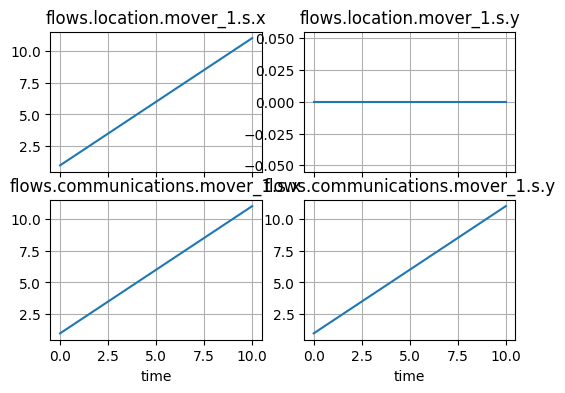

In [11]:
fig, ax = mdlhist.plot_line('flows.location.mover_1.s.x', 'flows.location.mover_1.s.y', 
                            'flows.communications.mover_1.s.x', 'flows.communications.mover_1.s.y') 